In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

#ignore warning messages 
# import warnings
# warnings.filterwarnings('ignore') 

# sns.set()

###### Voor Tensorflow-GPU ########

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Load the data
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

In [3]:
Y_train = train["label"]
Y_test = test["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 
X_test = test.drop(labels = ["label"],axis = 1) 

# free some space
del train 
del test

In [4]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

In [6]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)
Y_test = to_categorical(Y_test, num_classes = 10)

In [7]:
# Split the train and the validation set for the fitting
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=0)

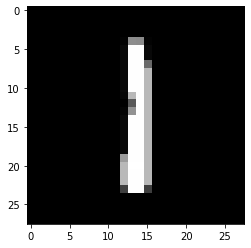

In [8]:
g = plt.imshow(X_train[2], cmap="gray")

In [9]:
print(X_train[2].shape)

(28, 28, 1)


In [10]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential(name="mnist_model")

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), name="mnist_input"))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax", name="mnist_output"))

In [11]:
# Define the optimizer
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [12]:
# Compile the model
model.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist_input (Conv2D)         (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          

In [13]:
# Set a learning rate annealer
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.00001)

In [14]:
earlystopper = EarlyStopping(patience=5, verbose=1)
epochs = 100 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 32

In [15]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [16]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [18]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 3, validation_data = (X_test,Y_test),
                              verbose = 1, callbacks=[earlystopper])

Epoch 1/3
938/938 [==============================] - 11s 12ms/step - loss: 0.1060 - accuracy: 0.9686 - val_loss: 0.0453 - val_accuracy: 0.9853
Epoch 2/3
938/938 [==============================] - 11s 12ms/step - loss: 0.0884 - accuracy: 0.9741 - val_loss: 0.0397 - val_accuracy: 0.9874
Epoch 3/3
938/938 [==============================] - 11s 12ms/step - loss: 0.0850 - accuracy: 0.9752 - val_loss: 0.0257 - val_accuracy: 0.9923


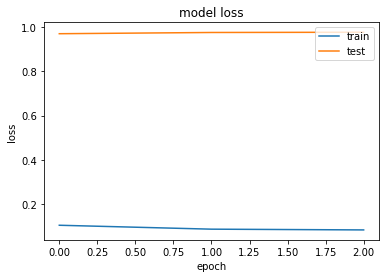

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

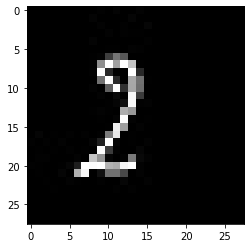

In [41]:
dink = [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 62, 117, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 143, 255, 161, 254, 197, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 254, 41, 1, 0, 255, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 113, 253, 42, 0, 168, 114, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 96, 255, 49, 167, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 10, 1, 247, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 15, 249, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 173, 153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 253, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 239, 159, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 1, 0, 2, 0, 2, 0, 2, 124, 232, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 3, 0, 0, 0, 5, 32, 255, 6, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0, 253, 60, 3, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 3, 0, 197, 148, 6, 0, 3, 123, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 6, 30, 255, 252, 255, 178, 171, 247, 255, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 5, 0, 176, 247, 0, 16, 114, 113, 72, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 1, 0, 0, 2, 0, 0, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dink = np.array(dink)
dink = dink / 255.0
g = plt.imshow(dink.reshape(28,28,1), cmap="gray")
dink = dink.reshape(-1, 28, 28, 1)

In [42]:
print(dink.shape)

(1, 28, 28, 1)


In [22]:
# predict results
results = model.predict(dink)
print(results[0])
for i in results[0]:
    print(f"{np.where(results[0] == i)[0][0]} has prob of {round(i,2)}")

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
print(f"Closest number is {results[0]}")

[0.00536442 0.08463486 0.7987229  0.01003878 0.01352202 0.00623416
 0.00249375 0.02294049 0.03221908 0.02382957]
0 has prob of 0.009999999776482582
1 has prob of 0.07999999821186066
2 has prob of 0.800000011920929
3 has prob of 0.009999999776482582
4 has prob of 0.009999999776482582
5 has prob of 0.009999999776482582
6 has prob of 0.0
7 has prob of 0.019999999552965164
8 has prob of 0.029999999329447746
9 has prob of 0.019999999552965164
Closest number is 2


In [25]:
results = model.predict(dink)
print(results)

[[0.00536442 0.08463486 0.7987229  0.01003878 0.01352202 0.00623416
  0.00249375 0.02294049 0.03221908 0.02382957]]


In [26]:
# KERAS MODEL OPSLAAN

import keras2onnx
print("keras2onnx version is "+keras2onnx.__version__)

keras2onnx version is 1.8.0


In [27]:
# convert to onnx model
onnx_model = keras2onnx.convert_keras(model, 'mnist-onnx-v2', debug_mode=1)
output_model_path = "./mnist-onnx-v2.onnx"
# and save the model in ONNX format
keras2onnx.save_model(onnx_model, output_model_path)

tf executing eager_mode: True
tf.keras model eager_mode: False
Processing a keras layer - (mnist_output: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: mnist_output/Softmax:0
	input : dropout_2/cond/Identity:0
Processing a keras layer - (dropout_2: <class 'tensorflow.python.keras.layers.core.Dropout'>)
	output: dropout_2/cond/Identity:0
	input : dense/Relu:0
Processing a keras layer - (dense: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense/Relu:0
	input : flatten/Reshape:0
Processing a keras layer - (flatten: <class 'tensorflow.python.keras.layers.core.Flatten'>)
	output: flatten/Reshape:0
	input : dropout_1/cond/Identity:0
Processing a keras layer - (dropout_1: <class 'tensorflow.python.keras.layers.core.Dropout'>)
	output: dropout_1/cond/Identity:0
	input : max_pooling2d_1/MaxPool:0
Processing a keras layer - (max_pooling2d_1: <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>)
	output: max_pooling2d_1/MaxPool:0
	input : conv2d_2/Relu:0
P

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist_input (Conv2D)         (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          

Converting the operator (flatten): <class 'tensorflow.python.keras.layers.core.Flatten'>
Converting the operator (flatten/Const): Const
Converting the operator (dropout_1): <class 'tensorflow.python.keras.layers.core.Dropout'>
Converting the operator (max_pooling2d_1): <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>
Converting the operator (conv2d_2): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (conv2d_1): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (dropout): <class 'tensorflow.python.keras.layers.core.Dropout'>
Converting the operator (max_pooling2d): <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>
Converting the operator (conv2d): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (mnist_input): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (Identity3): Identity


In [39]:
import json
import onnxruntime

In [35]:
session = onnxruntime.InferenceSession("mnist-onnx-v2.onnx", None)

In [36]:
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
print(input_name)
print(output_name)

mnist_input_input
mnist_output


In [46]:
result = session.run([output_name], {input_name: dink.astype('float32')})
print(result)
prediction=int(np.argmax(np.array(result).squeeze(), axis=0))
print(prediction)

[array([[0.00536442, 0.08463484, 0.79872304, 0.01003877, 0.01352201,
        0.00623415, 0.00249375, 0.02294048, 0.03221906, 0.02382956]],
      dtype=float32)]
2


In [28]:
print(model.inputs[0])
print(model.output.name)

Tensor("mnist_input_input:0", shape=(None, 28, 28, 1), dtype=float32)
mnist_output/Softmax:0


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [30]:
print('Predict the test set')
predict = model.predict(X_test, batch_size=batch_size)
predict = np.argmax(predict,axis=1)
class_report = classification_report(Y_test.argmax(axis=1),predict,target_names=[str(i) for i in range(10)])
print(class_report)
#run.log("Classification report", class_report)

cf = confusion_matrix(Y_test.argmax(axis=1), predict)
#run.log("Confusion Matrix", cf)

print(cf)
acc = accuracy_score(Y_test.argmax(axis=1), predict) * 100
print(acc)

Predict the test set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1195
           1       1.00      0.99      1.00      1352
           2       0.99      1.00      0.99      1157
           3       0.99      0.99      0.99      1258
           4       0.99      1.00      0.99      1140
           5       1.00      0.99      0.99      1076
           6       0.99      1.00      1.00      1167
           7       0.99      0.99      0.99      1268
           8       0.99      0.99      0.99      1174
           9       0.99      0.97      0.98      1213

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000

[[1188    0    0    0    0    0    6    0    1    0]
 [   1 1343    1    1    0    0    1    5    0    0]
 [   0    0 1155    2    0    0    0    0    0    0]
 [   0    0    3 1251    0    1    0    1    1    1]
 [   0  

In [ ]:
predict = model.predict(X_test, batch_size=batch_size)